# Configuration Code

In [29]:
%pip install gspread_pandas
%pip install fooddatacentral
%pip install pint
%pip install cufflinks
%pip install CFEDemands


from  scipy.optimize import linprog as lp
import numpy as np
import warnings
import pandas as pd
import eep153_tools
from eep153_tools.sheets import read_sheets
import fooddatacentral as fdc
import cufflinks as cf


from cfe import Regression

cf.go_offline()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# (A) Choice of Population, with supporting expenditure


We chose to analyze the Ugandan popultion of males and females 19-30 


Ugandan Expenditures of 2019-20 

In [30]:
Uganda_Data = '1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ'

x = read_sheets(Uganda_Data,sheet='Expenditures (2019-20)') 
x.columns.name = 'j'

Key available for students@eep153.iam.gserviceaccount.com.


Ugandan Household characteristics 

In [31]:
d = read_sheets(Uganda_Data,sheet="HH Characteristics") 
d.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.


In [32]:
x = x.groupby('j',axis=1).sum() #reducing duplicate columns
x = x.replace(0,np.nan) #reducing nulls
y = np.log(x.set_index(['i','t','m'])) #log of expenditure 
d.set_index(['i','t','m'],inplace=True) #specific labels for the axis


use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]


#Filtering it down to our population of interest (M,F 19-30) 
b = read_sheets(Uganda_Data,sheet='RDI')
b = b.set_index('n')



Key available for students@eep153.iam.gserviceaccount.com.


# (A) Estimate Demand System


In [33]:
from cfe.estimation import drop_columns_wo_covariance
y = drop_columns_wo_covariance(y,min_obs=30)
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]

#y is log expednitures on food j by household i at a particular time
y = y.stack()
d = d.stack()
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

#setting up the regression
result = Regression(y=y,d=d)
#predicting expenditures
result.predicted_expenditures()

i                                 t        m         j             
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern   Beans             3555.677276
                                                     Beef              8401.789558
                                                     Biscuits           842.091521
                                                     Bread             3077.266434
                                                     Cabbages          1199.255865
                                                                          ...     
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern  Sweet Potatoes    6706.688800
                                                     Tea                201.911345
                                                     Tomatoes          1349.788766
                                                     Waragi            4423.328381
                                                     Yam               2839.871449
Length: 101010, dty

Comparing Predicted Log Expenditures with Actual Expenditures

<IPython.core.display.Javascript object>


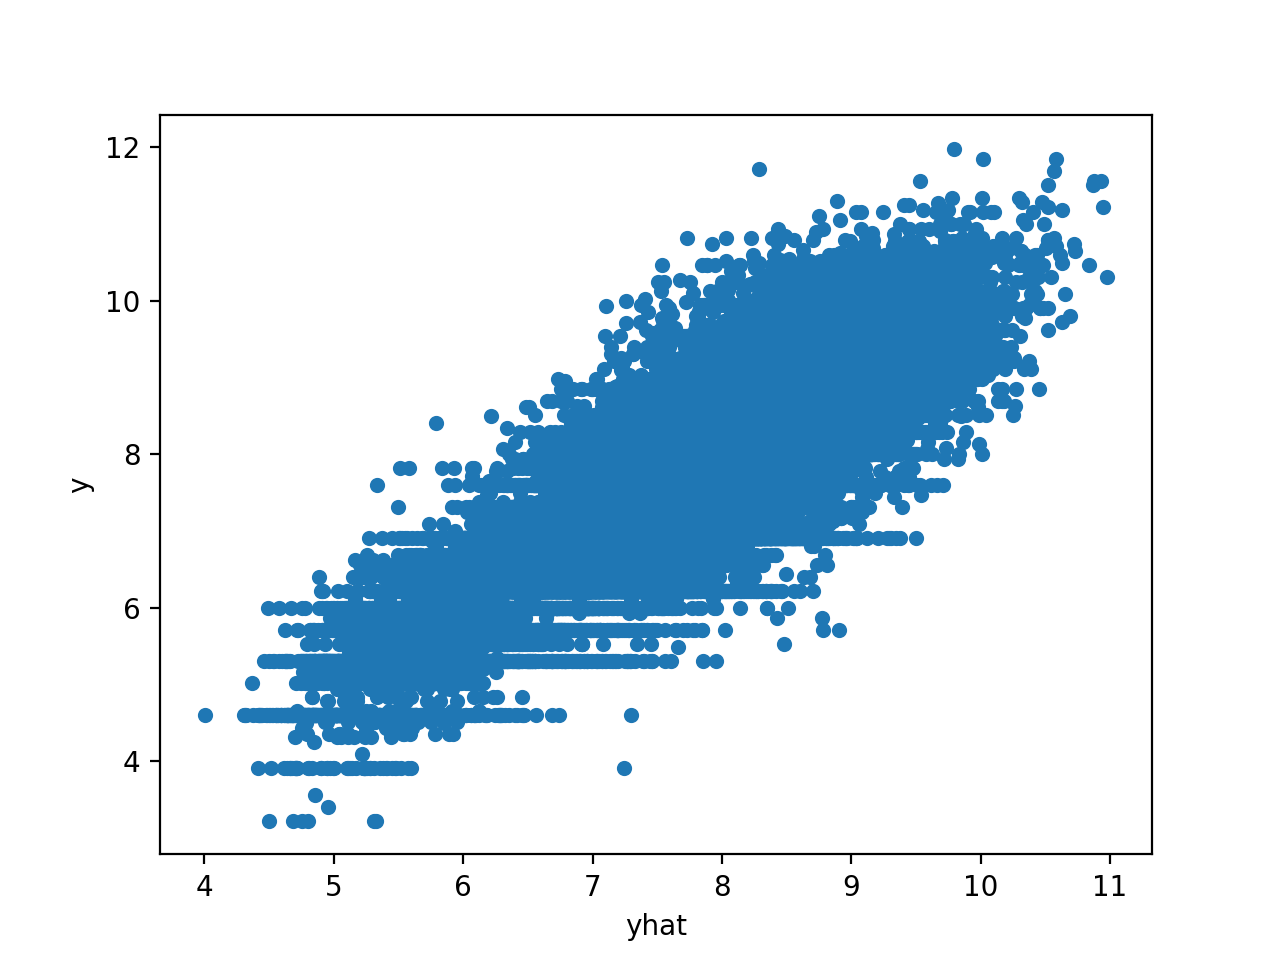

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [34]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

Demand and Household Composition
Relative to the average consumption, the characteristics of age and sex affect the demand of the household in this factor. 

In [38]:
result.gamma

k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,log HSize,Constant
j,,,,,,,,,,,,,,,,
Beans,-0.124336,0.035231,0.090377,0.004499,-0.007870,0.022907,0.102685,-0.042510,0.022145,0.064256,0.063150,0.041227,0.011180,0.114473,0.391925,-0.765806
Beef,-0.133073,0.012580,0.015526,0.014861,0.082507,0.061304,0.189160,-0.042146,0.021119,-0.009366,0.048574,0.077610,0.170483,0.171712,0.252517,-0.676754
Biscuits,0.038606,-0.000608,-0.026963,0.101941,0.015177,0.244867,0.289385,0.243284,0.039812,-0.050499,-0.058406,0.046866,0.170904,-0.127918,-0.075380,-0.409758
Bread,-0.064686,0.027238,-0.092955,-0.008487,0.061894,0.057456,0.084374,-0.128560,0.073478,-0.041311,-0.019199,0.013019,0.074366,0.078168,0.398146,-0.751295
Cabbages,0.007378,-0.058572,0.029930,0.037955,-0.026252,0.036936,0.081504,-0.045031,0.033217,0.013162,0.042502,0.069609,0.030480,0.068790,0.232485,-0.513702
Cassava,0.019206,0.089485,0.105922,0.042049,-0.004145,0.072680,0.156273,-0.003705,0.134056,0.186236,0.135270,0.062836,0.098303,0.118365,0.148453,-0.711646
Chapati,-0.034054,-0.008517,0.065749,0.090993,0.023017,0.006971,-0.090070,0.007639,0.082807,-0.036377,-0.016584,0.067900,0.093947,0.153264,0.162986,-0.412577
Cooking Oil,-0.088741,-0.050446,-0.052850,0.011923,0.028813,0.017072,-0.079372,-0.086822,-0.083002,-0.041623,-0.007363,-0.034479,0.005265,0.052592,0.418256,-0.517449
Dodo,-0.083900,-0.011246,0.091461,0.040517,0.049264,0.073878,0.182246,-0.021156,0.021386,0.088145,-0.009156,0.044575,0.063169,0.162541,0.170590,-0.539539


# (B) Nutritional Content of Different Foods


In [39]:
#code


# (B) Nutritional Adequacy of Diet


In [40]:
#helper function
def helper(age, sex): 
    if (age < 4):
        group = str(sex) + ' 00-03'
    elif age < 9: 
        group = str(sex) + ' 04-08'
    elif age < 14:
        group = str(sex) + ' 09-13'
    elif age < 19:
        group = str(sex) + ' 14-18'
    elif age < 31:
        group = str(sex) + ' 19-30'
    elif age < 51:
        group = str(sex) + ' 31-50'
    else: # over 51: 
        group = str(sex) + ' 51+'
    return group


def dietary_ref_index(age, sex):
    group = helper(age, sex)
    series = (b[group])
    return series 

dietary_ref_index(22, 'M')

#Create a table where the expenditures are mapped to the foods and their correspodning nutritions
#compare the nutritional expenses to the RDI guide 
#where are they lacking, or what percent of households are eating adequatley 



n
Energy          2400.0
Protein           56.0
Fiber             33.6
Folate           400.0
Calcium         1000.0
Carbohydrate     130.0
Iron               8.0
Magnesium        400.0
Niacin            16.0
Phosphorus       700.0
Potassium       4700.0
Riboflavin         1.3
Thiamin            1.2
Vitamin A        900.0
Vitamin B-12       2.4
Vitamin B-6        1.3
Vitamin C         90.0
Vitamin E         15.0
Vitamin K        120.0
Zinc              11.0
Name: M 19-30, dtype: float64